<h3 align='center'><b>PROJECT TITLE - Name Entity Recognition (NER) on WIESP Dataset</b></h3>

**Team Name: Task Force-X**

**Team Members** -<br>
*   Abhishek
*   Ishani 
*   Shruti
*   Tharun

**PROBLEM STATEMENT** - <br>
Information Extraction From Scientific Publication. 

**DESCRIPTION** - <BR>
Named Entity Recognition (NER) is one of the most popular applications of Natural Language Processing. For the scope of this project, we will focus on creating a NER model that identifies key tokens and classifies them into set of predefined entities.

**DATASET** -<br>
Datasets with text fragments from astrophysics papers, provided by the NASA Astrophysical Data System with manually tagged astronomical facilities and other entities of interest (e.g., celestial objects).
Datasets are in JSON Lines format (each line is a json dictionary).
The datasets are formatted similarly to the CONLL2003 format. Each token is associated with an NER tag. The tags follow the "B-" and "I-" convention from the IOB2 syntax

Each entry consists of a dictionary with the following keys:

*  "unique_id": a unique identifier for this data sample. Must be included in the predictions.
*  "tokens": the list of tokens (strings) that form the text of this sample. Must be included in the predictions.
*  "ner_tags": the list of NER tags (in IOB2 format)
*   "ner_ids": ids corresponding to NER tags.


**OUR APPROACH TO THIS PROBLEM STATEMENT**-<br>
1. **Reading the JSONL train and test data (JSON lines data) in dataframe.** 
2. **Data Pre-processing.**<br>
   2.1 - Exploding the train_data using df.explode() to get separate tokens and its corresponding NER tags and ids. <br>
   2.2 - Creating a dictionary of NER tags corresponding to its respective NER ids which would be useful later to convert the predicted tag id to NER tags.<br>
   2.3 - Dropping punctuation tokens having tag as 'O'.<br>
   2.4 - Checking the distribution of NER tags in train data.<br>
   2.5 - Creating back sentences from tokens (as intitial train data had).<br>
   2.6 - Checking the distribution of length of sentences and dropping outlier sentences (having length<10 or length>600) from train_data.
3. **Tokenizing the data (Implementing tokenizer from scratch).**<br>
   3.1 - Creating vocabulary based on train data having vocab_size of 5000.<br>
   3.2 - Tokenizing train_data sentence tokens using the train_data vocabulary created.<br>
   3.3 - Tokenizing test_data sentence tokens using the train_data vocabulary.
4. **Splitting the data in train and validation splits.**
5. **Creating the tensorflow dataset.**
6. **Building models.**<br>
   6.1 - Baseline Model: A simple RNN network with 2 layers.<br>
   6.2 - Bidirectional LSTM model. (2 Bidirectional LSTM layers)<br>
   6.3 - Baseline Model: A simple RNN network with 2 layers using Word2Vec Embeddings.<br>
   6.4 - Bidirectional LSTM model using Word2Vec Embeddings.<br>
   6.5 - Comparison of models.<br>
7. **Evaluating model using validation data.**<br>
   7.1 - Classification report.<br>
   7.2 - Actual tags VS Predicted tags for a validation input.<br>
8. **Making predictions on test data.**
9. **Conclusion.**

#### **Importing the required libraries**

In [ ]:
import requests
import re
import os
import gc
import collections
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import HTML

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from prettytable import PrettyTable
from collections import defaultdict
from collections import Counter
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Dense, SimpleRNN, TimeDistributed,Bidirectional
from gensim.models import KeyedVectors

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

#### **1. Reading the JSONL (JSON lines data) in dataframe.**

In [ ]:
# Mounting drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_data_path = "/content/gdrive/MyDrive/Univ.AI/AI3/AI3_Project/WIESP2022-NER-TRAINING.jsonl"
test_data_path = "/content/gdrive/MyDrive/Univ.AI/AI3/AI3_Project/WIESP2022-NER-VALIDATION-NO-LABELS.jsonl"

# Reading the train and test data in train_data and test_data dataframes respectively
train_data = pd.read_json(train_data_path, lines=True)
test_data = pd.read_json(test_data_path, lines=True)

In [ ]:
# Printing the shape of train_data and viewing first few rows of it
print("Shape of train data: ",train_data.shape)
train_data.head()

Shape of train data:  (1753, 7)


,bibcode,label_studio_id,ner_ids,ner_tags,section,tokens,unique_id
0,2019MNRAS.486.5558S,487,"[62, 62, 62, 62, 62, 62, 62, 15, 62, 62, 62, 6...","[O, O, O, O, O, O, O, B-Instrument, O, O, O, O...",fulltext,"[Whilst, a, reasonable, harmonic, fit, to, the...",fulltext_487_2019MNRAS.486.5558S
1,2018MNRAS.478.5533F,1129,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",fulltext,"[comparison, once, the, angular, positions, of...",fulltext_1129_2018MNRAS.478.5533F
2,2018MNRAS.480.3062L,1086,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",acknowledgments,"[ACKNOWLEDGEMENTS, The, authors, thank, an, an...",acknowledgments_1086_2018MNRAS.480.3062L
3,2016MNRAS.457.1786M,1135,"[22, 62, 62, 62, 62, 21, 13, 44, 44, 21, 62, 1...","[B-Person, O, O, O, O, B-Organization, B-Grant...",acknowledgments,"[BDM, gratefully, acknowledges, support, from,...",acknowledgments_1135_2016MNRAS.457.1786M
4,2019MNRAS.482L...9B,559,"[62, 62, 62, 22, 53, 22, 53, 22, 53, 22, 53, 2...","[O, O, O, B-Person, I-Person, B-Person, I-Pers...",acknowledgments,"[ACKNOWLEDGEMENTS, We, thank, Dougal, Mackey,,...",acknowledgments_559_2019MNRAS.482L...9B


In [ ]:
# Viewing the columns in train_data
train_data.columns

Index(['bibcode', 'label_studio_id', 'ner_ids', 'ner_tags', 'section',
       'tokens', 'unique_id'],
      dtype='object')

As seen from above, train data has 1753 word tokenized sentences and has 7 columns 'bibcode', 'label_studio_id', 'ner_ids', 'ner_tags', 'section' 'tokens', 'unique_id' where,
1. bibcode: Each sentence have a common bibcode. 
2. label_studio_id: Unique label id.
3. ner_ids: Encoded values for the ner_tags. 
4. ner_tags: Tags corresponding to sentence tokens.
4. section: Type of sentence.
5. tokens: These are the words for which the model needs to find which entities these are.
6. unique_id: Unique id.

In [ ]:
# Printing the shape of test_data and viewing first few rows of it
print("Shape of test data: ",test_data.shape)
test_data.head()

Shape of test data:  (1366, 5)


,bibcode,label_studio_id,section,tokens,unique_id
0,2016A&A...586A.140P,1778,fulltext,"[that, gas, outside, halos,, not, necessarily,...",fulltext_1778_2016A&A...586A.140P
1,2017ApJ...842..123F,1466,fulltext,"[that, all, star, formation, within, Upper, Sc...",fulltext_1466_2017ApJ...842..123F
2,2019ApJ...882L...1F,1015,fulltext,"[the, PCs, would, contain, the, changes., Mate...",fulltext_1015_2019ApJ...882L...1F
3,2018MNRAS.475.3029T,72,fulltext,"[arcmin, away,, in, a, low, density, environme...",fulltext_72_2018MNRAS.475.3029T
4,2019ApJ...876..136J,57,acknowledgments,"[We, are, grateful, to, J., Chen,, J., Delabro...",acknowledgments_57_2019ApJ...876..136J


The test data has 1366 word tokenized sentences having same columns as train except the NER tags and NER ids which we have to predict.

#### **2. Data Pre-processing**

In [ ]:
# Keeping only the required columns from train_data['ner_ids','ner_tags','tokens'] and test_data['tokens']
train_data = train_data[['ner_ids','ner_tags','tokens']]
print("Shape of train_data: ", train_data.shape)

test_data = test_data[['tokens']]
print("Shape of test_data: ", test_data.shape)

Shape of train_data:  (1753, 3)
Shape of test_data:  (1366, 1)


##### **2.1 - Exploding the train_data using df.explode() to get separate tokens and its corresponding NER tags and ids.** 

In [ ]:
# Using df.explode on train_data for columns 'ner_ids','ner_tags' and 'token'
# to separate tokens and its corresponding ner tags and ids
train_data = train_data.explode(['ner_ids','ner_tags','tokens'])
print("Train data shape after separating tokens and its corresponding ner tags and ids: ",train_data.shape)

# Viewing first few rows of exploded train_data
train_data.head()

Train data shape after separating tokens and its corresponding ner tags and ids:  (573132, 3)


,ner_ids,ner_tags,tokens
0,62,O,Whilst
0,62,O,a
0,62,O,reasonable
0,62,O,harmonic
0,62,O,fit


Exploding would create a separate row for each word token in sentence with corresponding NER tags and NER ids for ease of cleaning i.e. removing punctation tokens. <br>
Train data shape after separating tokens and its corresponding ner tags and ids: (573132, 3)

##### **2.2 - Creating a dictionary of NER tags corresponding to its respective NER ids which would be useful later to convert the predicted tag id to NER tags.** 

In [ ]:
# Getting the unique ner_ids and its corresponding tags
unique_tags_and_ids = train_data[['ner_ids','ner_tags']]
unique_tags_and_ids.drop_duplicates(inplace=True)
unique_tags_and_ids.sort_values(by='ner_ids',inplace=True)
unique_tags_and_ids.head()

,ner_ids,ner_tags
15,0,B-Archive
6,1,B-CelestialObject
7,2,B-CelestialObjectRegion
14,3,B-CelestialRegion
0,4,B-Citation


In [ ]:
# Converting the unique_tags_and_ids dataframe to dictionary
# with ner_id as key as its corresponding tag as value
ner_id_tags_dict = pd.Series(unique_tags_and_ids.ner_tags.values,
                             index = unique_tags_and_ids.ner_ids).to_dict()

# Printing the 'ner_id_tags_dict' and length of ner_id_tags_dict 
print("Total NER ids: ",len(ner_id_tags_dict))
print("Dictonary containing NER ids as keys and its corresponding NER tag as value: ")
print(ner_id_tags_dict)

Total NER ids:  63
Dictonary containing NER ids as keys and its corresponding NER tag as value: 
{0: 'B-Archive', 1: 'B-CelestialObject', 2: 'B-CelestialObjectRegion', 3: 'B-CelestialRegion', 4: 'B-Citation', 5: 'B-Collaboration', 6: 'B-ComputingFacility', 7: 'B-Database', 8: 'B-Dataset', 9: 'B-EntityOfFutureInterest', 10: 'B-Event', 11: 'B-Fellowship', 12: 'B-Formula', 13: 'B-Grant', 14: 'B-Identifier', 15: 'B-Instrument', 16: 'B-Location', 17: 'B-Mission', 18: 'B-Model', 19: 'B-ObservationalTechniques', 20: 'B-Observatory', 21: 'B-Organization', 22: 'B-Person', 23: 'B-Proposal', 24: 'B-Software', 25: 'B-Survey', 26: 'B-Tag', 27: 'B-Telescope', 28: 'B-TextGarbage', 29: 'B-URL', 30: 'B-Wavelength', 31: 'I-Archive', 32: 'I-CelestialObject', 33: 'I-CelestialObjectRegion', 34: 'I-CelestialRegion', 35: 'I-Citation', 36: 'I-Collaboration', 37: 'I-ComputingFacility', 38: 'I-Database', 39: 'I-Dataset', 40: 'I-EntityOfFutureInterest', 41: 'I-Event', 42: 'I-Fellowship', 43: 'I-Formula', 44: 'I-

##### **2.3 - Dropping punctuation tokens having tag as 'O'.** 

In [ ]:
# Checking the number of tags which are punctuation and have tag as 'O'
TagO_and_Tokpunc = train_data[(train_data['ner_tags']=='O') & (train_data['tokens'].isin(list('?$#@./|:()",;[]{}-')))]
print("Number of tags which are punctuation and have tag as 'O': ",TagO_and_Tokpunc.shape[0])

# Viewing first few rows of the punctuation tokens
TagO_and_Tokpunc.head()

Number of tags which are punctuation and have tag as 'O':  9719


,ner_ids,ner_tags,tokens
0,62,O,(
0,62,O,)
0,62,O,(
0,62,O,)
0,62,O,(


As seen from the above output, there are 9719 tokens which are punctuation markers and have tag as 'O' (Other). Removing these rows (tokens) from train data as this would clean the data and reduce the 'O' tag dominance in train data to some extent.

In [ ]:
# Removing tokens which are punctuation and have tag as 'O' from train_data
train_data = train_data[~((train_data['ner_tags']=='O') & (train_data['tokens'].isin(list('?$#@./|:()",;[]{}-'))))]
print("Shape of train data after removing tags which are punctuation and have tag as 'O': ",train_data.shape)

Shape of train data after removing tags which are punctuation and have tag as 'O':  (563413, 3)


##### **2.4 - Checking the distribution of NER tags in train data.** 

In [ ]:
# Checking the distribution of ner_tags
train_data['ner_tags'].value_counts()

O                           462588
I-Citation                   18402
I-Organization               14211
I-Formula                     8433
B-Organization                7448
                             ...  
B-Event                         45
I-Identifier                    31
I-Mission                       27
I-EntityOfFutureInterest        16
I-URL                           12
Name: ner_tags, Length: 63, dtype: int64

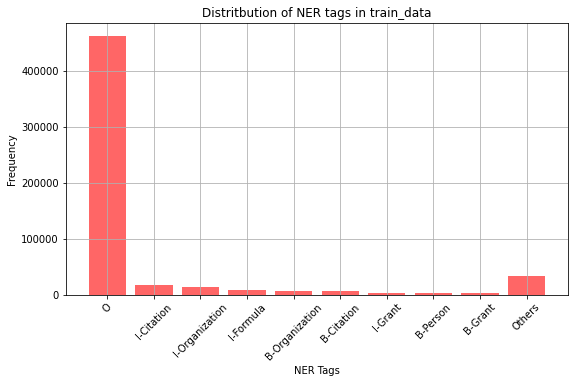

In [ ]:
### Plotting the distribution of ner_tags ###

# Keeping the top 9 most occuring tags and adding the other tags together in 'Others'
tag_freq = pd.DataFrame(train_data['ner_tags'].value_counts()[:9])
tag_freq.reset_index(inplace=True)
tag_freq.rename(columns = {'index':'NER_tag', 'ner_tags':'Frequency'}, inplace = True)
others = np.sum(train_data['ner_tags'].value_counts()[9:])

# Adding the 'Others' (sum of rest of the tags count) to tag_freq dataframe
tag_freq.loc[len(tag_freq.index)] = ['Others', others] 

# Plotting the bar chart
plt.figure(figsize=(9,5))
plt.bar(x = tag_freq['NER_tag'],height = tag_freq['Frequency'],
        color = 'r', alpha = 0.6)
plt.title("Distritbution of NER tags in train_data")
plt.xlabel("NER Tags")
plt.xticks(rotation = 45)
plt.ylabel("Frequency")
plt.grid()

As seen from the above bar plot, their is a huge dominance of 'O' (Other) tag leading to huge imbalance of classes in the train data.

**For the model to predict well after training on such imbalance data, we have to give data in smaller batches while training the model so that model could learn other tags too. If we give data in large batches, due to the dominance of 'O' tag other tags would go unnoticed.**

##### **2.5 - Creating sentences from tokens (as intitial train data had).**
As the pre-processing i.e. removing of punctuation tokens which had tag as 'O', creating sentences  (as the initial train data had) from tokens by grouping them on index as the model would require the complete sentence as input as its corresponding tags as target.

In [ ]:
# Creating sentences by grouping on index and the sentences respective ner_tokens and ids 
train_data = train_data.groupby(train_data.index).agg({'ner_ids': lambda x: x.tolist(),
                                                       'ner_tags': lambda y: y.tolist(),
                                                       'tokens': lambda z: z.tolist()})

print("Shape of train_data: ",train_data.shape)
train_data.head()

Shape of train_data:  (1753, 3)


,ner_ids,ner_tags,tokens
0,"[62, 62, 62, 62, 62, 62, 62, 15, 62, 62, 62, 6...","[O, O, O, O, O, O, O, B-Instrument, O, O, O, O...","[Whilst, a, reasonable, harmonic, fit, to, the..."
1,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[comparison, once, the, angular, positions, of..."
2,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[ACKNOWLEDGEMENTS, The, authors, thank, an, an..."
3,"[22, 62, 62, 62, 62, 21, 13, 44, 44, 21, 62, 1...","[B-Person, O, O, O, O, B-Organization, B-Grant...","[BDM, gratefully, acknowledges, support, from,..."
4,"[62, 62, 62, 22, 53, 22, 53, 22, 53, 22, 53, 2...","[O, O, O, B-Person, I-Person, B-Person, I-Pers...","[ACKNOWLEDGEMENTS, We, thank, Dougal, Mackey,,..."


##### **2.6 - Checking the distribution of length of sentences and dropping outlier sentences (having length<10 or length>600) from train_data.**

Text(0.5, 1.0, 'Distribution of length of texts')

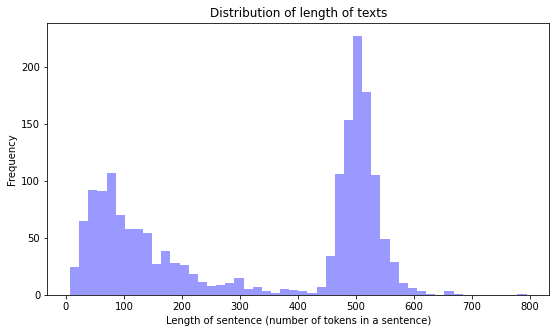

In [ ]:
### Checking the distribution of length of sentences in train data ###
sentence_length = []
for sentence in train_data.tokens:
  sentence_length.append(len(sentence))

### Plotting the distribution of length of sentences ###
plt.figure(figsize=(9,5))
plt.hist(sentence_length, bins = 50, color = 'b', alpha = 0.4)
plt.xlabel("Length of sentence (number of tokens in a sentence)")
plt.ylabel("Frequency")
plt.title("Distribution of length of texts")

As seen above histogram, there is huge difference between the lenght of sentences. Some sentences are too short while some are too large. Dropping the sentences whose length is less than 10 or greater than 600 to maintain some range by dropping outliers.

In [ ]:
# Dropping the sentences whose length is less than 10 or greater than 600 
for idx in train_data.index:
  len_sent = len(train_data['tokens'][idx])
  if len_sent<10 or len_sent>600:
    train_data.drop(idx, inplace=True)

# Printing the shape of train_data
print("Shape of train_data after dropping the outlier sentences: ",train_data.shape)

Shape of train_data after dropping the outlier sentences:  (1739, 3)


#### **3. Tokenizing the data (Implementing tokenizer from scratch)**

##### **3.1 - Creating vocabulary based on train data having vocab_size of 5000.**

In [ ]:
### Creating a function that takes in df and returns a dictionary with a mapping of token to number for 'tokens' column
def tokenizer(df):

    # Use counter to count the frequency of each token
    top = Counter([item for sublist in df['tokens'] for item in sublist])

    # Create a dataframe 'temp' which contain all tokens in an order of their frequency
    temp = pd.DataFrame(top.most_common(5000))
    temp.columns = ['Token','Frequency']

    # Setting index of temp df from 2 as we would map these index with tokens and 
    # index 1 would be used for <UNK> token 
    temp.index = list(range(2,temp.shape[0]+2))

    # Create a dictionary which would contain token as key and it's index as value from temp df
    vocabulary = {v:k for k, v in temp['Token'].to_dict().items()}

    # Get the position of first item in vocabulary dict using temp df and 
    # add <UNK> token at that position with its value as 1
    pos = list(vocabulary.keys()).index(temp.iloc[0,0])
    items = list(vocabulary.items())
    items.insert(pos, ('<UNK>', 1))
    vocabulary = dict(items)

    # Printing the size of vocabulary
    print("Size of vocabulary: ",len(vocabulary))

    # Returning vocabulary dict
    return vocabulary


### Using the above function on train set and printing first 10 items from returned dictionary
vocab = tokenizer(train_data)
dict(list(vocab.items())[0: 10]) 

Size of vocabulary:  5001


{'<UNK>': 1,
 'a': 8,
 'and': 4,
 'by': 10,
 'for': 9,
 'in': 5,
 'is': 7,
 'of': 3,
 'the': 2,
 'to': 6}

##### **3.2 - Tokenizing train_data sentence tokens using the train_data vocabulary created above.** 

In [ ]:
### Getting train_data tokens in numerical representation using above vocabulary ###

# Creating a list 'vocab_Mapped_Tokens' which would contain 
# tokenized messages as per vocab dict
vocab_Mapped_Tokens = []

# For each row in train dataframe's 'tokens' column
for sentence in train_data['tokens']:
  # Creating a list 'mapped' which would contain numerical representation 
  # (from vocab dict) of the tokens present in that sentence
  mapped = []
  
  # Iterating through each sentences tokens
  for tok in sentence:
    # if word is present in vocab dicts key, append its value(token number) to 'mapped' list
    if tok in vocab.keys():
      mapped.append(vocab[tok])
    # else append the value of OOV token <UNK> which is 1
    else:
      mapped.append(vocab['<UNK>'])
  
  # Append these mapped list to vocab_Mapped_Tokens list
  # vocab_Mapped_Tokens list would contain mapped list for each of the sentences
  vocab_Mapped_Tokens.append(mapped)

# Add a column 'Tokenized_Data' column to train set which would contain Tokennized sentences 
# for the respective sentences using vocabulary
train_data['Tokenized_Data'] = vocab_Mapped_Tokens
train_data.head()

,ner_ids,ner_tags,tokens,Tokenized_Data
0,"[62, 62, 62, 62, 62, 62, 62, 15, 62, 62, 62, 6...","[O, O, O, O, O, O, O, B-Instrument, O, O, O, O...","[Whilst, a, reasonable, harmonic, fit, to, the...","[1, 8, 1439, 1, 203, 6, 2, 1, 36, 40, 25, 2854..."
1,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[comparison, once, the, angular, positions, of...","[465, 1623, 2, 321, 1203, 3, 2, 2543, 17, 1, 2..."
2,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[ACKNOWLEDGEMENTS, The, authors, thank, an, an...","[427, 12, 251, 50, 28, 197, 2175, 9, 193, 4, 6..."
3,"[22, 62, 62, 62, 62, 21, 13, 44, 44, 21, 62, 1...","[B-Person, O, O, O, O, B-Organization, B-Grant...","[BDM, gratefully, acknowledges, support, from,...","[1, 647, 79, 42, 13, 154, 1734, 62, 1, 346, 62..."
4,"[62, 62, 62, 22, 53, 22, 53, 22, 53, 22, 53, 2...","[O, O, O, B-Person, I-Person, B-Person, I-Pers...","[ACKNOWLEDGEMENTS, We, thank, Dougal, Mackey,,...","[427, 21, 50, 1, 1, 1, 1, 2242, 1, 1, 1, 2242,..."


##### **3.3 - Tokenizing test_data sentence tokens using the train_data vocabulary created above.**

In [ ]:
### Getting test_data tokens in numerical representation using above train_data vocabulary ###

# Creating a list 'vocab_Mapped_Tokens_test' which would contain 
# tokenized messages as per vocab dict
vocab_Mapped_Tokens_test = []

# For each row in test dataframe's 'tokens' column
for sentence in test_data['tokens']:
  # Creating a list 'mapped' which would contain numerical representation 
  # (from vocab dict) of the tokens present in that sentence
  mapped = []
  
  # Iterating through each sentences tokens
  for tok in sentence:
    # if word is present in vocab dicts key, append its value(token number) to 'mapped' list
    if tok in vocab.keys():
      mapped.append(vocab[tok])
    # else append the value of OOV token <UNK> which is 1
    else:
      mapped.append(vocab['<UNK>'])
  
  # Append these mapped list to vocab_Mapped_Tokens_test list
  # vocab_Mapped_Tokens_test list would contain mapped list for each of the sentences
  vocab_Mapped_Tokens_test.append(mapped)

# Add a column 'Tokenized_Data' column to test set which would contain Tokennized sentences 
# for the respective sentences using vocabulary
test_data['Tokenized_Data'] = vocab_Mapped_Tokens_test
test_data.head()

,tokens,Tokenized_Data
0,"[that, gas, outside, halos,, not, necessarily,...","[15, 98, 1289, 1, 39, 2663, 353, 266, 166, 172..."
1,"[that, all, star, formation, within, Upper, Sc...","[15, 74, 126, 199, 119, 3498, 1, 41, 1, 2209, ..."
2,"[the, PCs, would, contain, the, changes., Mate...","[2, 1, 96, 2023, 2, 1, 1, 15, 17, 1, 13, 2, 25..."
3,"[arcmin, away,, in, a, low, density, environme...","[3538, 1, 5, 8, 228, 78, 2182, 1, 14, 16, 1016..."
4,"[We, are, grateful, to, J., Chen,, J., Delabro...","[21, 17, 329, 6, 1846, 1, 1846, 1, 1, 1, 1846,..."


In [ ]:
# Printing the shape of train and test data
print("Shape of train_data: ",train_data.shape)
print("Shape of test_data: ",test_data.shape)

Shape of train_data:  (1739, 4)
Shape of test_data:  (1366, 2)


In [ ]:
# Resetting indexes of train_data and test_data
train_data.reset_index(drop=True, inplace = True)
test_data.reset_index(drop=True, inplace = True)

In [ ]:
# Storing the original train_data as df
train_data_df = train_data

#### **4. Splitting the data in train and validation splits (80-20 split).**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_data.Tokenized_Data, 
                                                  train_data.ner_ids, 
                                                  test_size=0.2, 
                                                  random_state=1)

# Printing the shape of train and validation data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  (1391,)
y_train shape:  (1391,)
X_val shape:  (348,)
y_val shape:  (348,)


In [ ]:
# Printing no. of sentences for train, validation and test
print("Number of sentences for training: ",X_train.shape[0])
print("Number of sentences for validation: ",X_val.shape[0])
print("Number of sentences for testing: ",test_data.shape[0])

Number of sentences for training:  1391
Number of sentences for validation:  348
Number of sentences for testing:  1366


#### **5. Creating the tensorflow dataset.**

For the model to predict well after training on such imbalance data, we have given data in smaller batches (batch size of 8) while training the model so that model could learn other tags too. 

If we give data in large batches, due to the dominance of 'O' tag other tags would go unnoticed.

In [ ]:
### Note - This code is taken from helper code of HW2 ###

# Small batch size for model to learn well on other tags than 'O' tag
batch_size = 8
train_shuffle_buffer_size = len(X_train)
validation_shuffle_buffer_size = len(X_val)

# Fill the required cells to complete the function
def transform_pad(input, output):
    
    # Pad the inputs
    input  = input.to_tensor(default_value=0, shape=[None, None])
    
    # Pad the outputs
    output = output.to_tensor(default_value=0, shape=[None, None])
    
    return input, output

train_processed_x = tf.ragged.constant(X_train)
validate_processed_x = tf.ragged.constant(X_val)
train_processed_y = tf.ragged.constant(y_train)
validate_processed_y = tf.ragged.constant(y_val)

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_processed_x, train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices((validate_processed_x, validate_processed_y))


#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
train_data = train_data.map(transform_pad, num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.prefetch(tf.data.AUTOTUNE)


##################
# Validation data
##################
# Apply all data processing logic
#validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
validation_data = validation_data.batch(batch_size)
validation_data = validation_data.map(transform_pad, num_parallel_calls=tf.data.AUTOTUNE)
validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

print("train_data", train_data)
print("validation_data", validation_data)

train_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>
validation_data <PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>


In [ ]:
# View some data from train_data tf dataset
print('Data from tf dataset:')
for inp, out in train_data.take(3):
  print(inp.shape)
  print(inp[0])

  print("************************")

  print(out.shape)
  print(out[0])

Data from tf dataset:
(8, 578)
tf.Tensor(
[   5    8  748  566    2  911    3    2 4165    4    1 1006   17 1998
    1  555   61    7  116  423    6 3176  152   23  381   40   25    1
    1  176 2059    1    2 2240    3    1    7 1359 4265    9    1  968
  157 1262    4   61    7    8  630 1056    9 1310    2  441  165    3
  416  124    3    2  452 1447  655    2  118  923   61 4689  210    6
   25 1998    1    9 1310    2  814 4312    3  416 1343 1120   34  191
    3 2333   20  694    8  608  465   47    2   88  109   70    2  440
    1 1620    4    5    2  381    3    1   34   45   60    2 4644  452
    4 1122  324  317  402    5    2 2657    3    8   95   92   17    1
    9    2    1  345    1  551   89    4    9    2    1  169    1  551
 1858 1626    2  440    1 1620 1710 1478    6    2 1620    5    2    1
  381    1 2155   26  381   41   82  109   10 3634    2    1 1908  227
  168 4379   74  118 1384  435    2    1 1908 4282   19  204    1   34
  118 4846   20    1    1    2    1

#### **6. Building Models.**

##### **6.1 - Baseline Model: A simple RNN network with 2 layers.**

In [ ]:
# Defining the vocab_size
vocab_size=len(vocab)

In [ ]:
tf.keras.backend.clear_session()

########## Baseline model architecture #########

# Defining the input
inputs = tf.keras.Input(shape=(None,), dtype=tf.float32)

# Defining Embedding layer to get embeddings from scratch
embedding_input = tf.keras.layers.Embedding(vocab_size+1, 300, mask_zero=True)(inputs)

# Defining the RNN layer 1
rnn1 = tf.keras.layers.SimpleRNN(300, return_sequences=True)
h1 = rnn1(embedding_input)

# Defining the RNN layer 2
rnn2 = tf.keras.layers.SimpleRNN(300,return_sequences=True)
h2 = rnn2(h1)

# Dense layer for prediction with activation as softmax
prediction = TimeDistributed(tf.keras.layers.Dense(63, activation='softmax'))(h2)

# Defining the baseline model
baseline_model = tf.keras.Model(inputs=(inputs,), outputs=prediction)

# Compiling the model using sparse_categorical_crossentropy as loss and Adam as optimizer
baseline_model.compile(loss='sparse_categorical_crossentropy', 
                       optimizer=tf.keras.optimizers.Adam(0.001),
                       metrics='accuracy')

In [ ]:
# Checking summary of Baseline model
baseline_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         1500600   
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 300)         180300    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 300)         180300    
                                                                 
 time_distributed (TimeDistr  (None, None, 63)         18963     
 ibuted)                                                         
                                                                 
Total params: 1,880,163
Trainable params: 1,880,163
Non-trainable params: 0
___________________________________________________

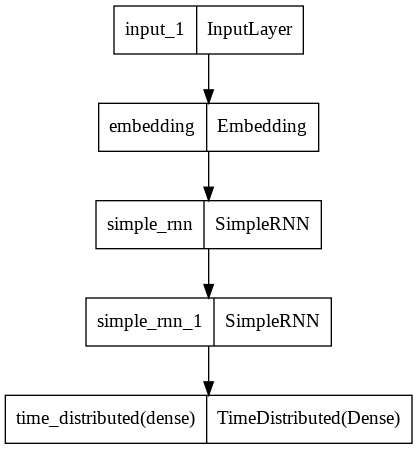

In [ ]:
#Architecture of baseline model 
tf.keras.utils.plot_model(baseline_model)

In [ ]:
# Fitting the model on train and val dataset
history_bm = baseline_model.fit(train_data, validation_data=validation_data, epochs=5)

Epoch 1/5
174/174 [==============================] - 249s 1s/step - loss: 0.5864 - accuracy: 0.8253 - val_loss: 0.4068 - val_accuracy: 0.8380
Epoch 2/5
174/174 [==============================] - 207s 1s/step - loss: 0.3097 - accuracy: 0.8861 - val_loss: 0.2643 - val_accuracy: 0.8892
Epoch 3/5
174/174 [==============================] - 207s 1s/step - loss: 0.2287 - accuracy: 0.9083 - val_loss: 0.2253 - val_accuracy: 0.9040
Epoch 4/5
174/174 [==============================] - 220s 1s/step - loss: 0.1896 - accuracy: 0.9216 - val_loss: 0.1999 - val_accuracy: 0.9136
Epoch 5/5
174/174 [==============================] - 242s 1s/step - loss: 0.1672 - accuracy: 0.9292 - val_loss: 0.1922 - val_accuracy: 0.9160


In [ ]:
# Saving the weights of baseline rnn model
baseline_model.save_weights('/content/gdrive/MyDrive/Univ.AI/AI3/AI3_Project/rnn_baseline_model_weights.pkl')

Text(0.5, 0.98, 'RNN Baseline model: Training and validation loss as well as accuracy as per the epochs')

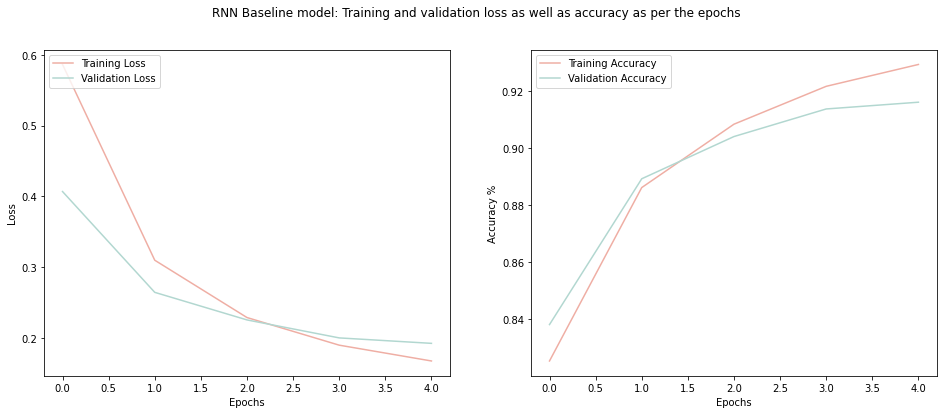

In [ ]:
# Plotting the training and validation loss and accuracy
fig, ax = plt.subplots(1,2,figsize = (16,6))
ax[0].plot(history_bm.history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history_bm.history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history_bm.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history_bm.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend(loc='upper left')
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('RNN Baseline model: Training and validation loss as well as accuracy as per the epochs')

In [ ]:
# Loading the saved weights of baseline model
baseline_model.load_weights('/content/gdrive/MyDrive/Univ.AI/AI3/AI3_Project/rnn_baseline_model_weights.pkl')

In [ ]:
# Checking the Performance of Baseline model on Train and val dataset
print("Baseline model's performance on train dataset: ", baseline_model.evaluate(train_data))
print("Baseline model's performance on validation dataset: ", baseline_model.evaluate(validation_data))

174/174 [==============================] - 40s 225ms/step - loss: 0.1492 - accuracy: 0.9358
Baseline model's performance on train dataset:  [0.14918461441993713, 0.9358131885528564]
44/44 [==============================] - 8s 184ms/step - loss: 0.1922 - accuracy: 0.9160
Baseline model's performance on validation dataset:  [0.19216026365756989, 0.9160115122795105]


In [ ]:
# Storing the train and validation accuracy of Baseline model
baseline_rnn_train_acc = baseline_model.evaluate(train_data)[1]
baseline_rnn_val_acc = baseline_model.evaluate(validation_data)[1]

44/44 [==============================] - 8s 188ms/step - loss: 0.1922 - accuracy: 0.9160


**Comments on baseline model -** <br>
As seen from above evaluation and accuracy,loss plots of baseline model with just 2 SimpleRNN layers and embeddings from scratch, the model is performing pretty well on train as well as validation data giving accuracy of 93.5% on train data and 91.6% on validation data.

##### **6.2 - Bidirectional LSTM model. (2 Bidirectional LSTM layers)** 
Using Bidirectional class. In Bidirectional LSTM, input flows in two directions, making it different from the regular LSTM. With the regular LSTM, we can make input flow in one direction, either backwards or forward. However, in bi-directional, we can make the input flow in both directions to preserve the future and the past information thereby improving model's performance.

We have used two Bidirectional LSTM layers in our architecture.

In [ ]:
tf.keras.backend.clear_session()

########## Bidirectional model with 2 layers #########

# Defining the input
inputs = tf.keras.Input(shape=(None,), dtype=tf.float32)

# Defining Embedding layer to get embeddings from scratch
embedding_input = tf.keras.layers.Embedding(vocab_size+1, 300, mask_zero=True)(inputs)

# Defining the bidirectional LSTM layer 1
bi_lstm1 = Bidirectional(tf.keras.layers.LSTM(300, return_sequences=True))
h1 = bi_lstm1(embedding_input)

# Defining the bidirectional LSTM layer 2
bi_lstm2 = Bidirectional(tf.keras.layers.LSTM(300,return_sequences=True))
h2 = bi_lstm2(h1)

# Dense layer for prediction with activation as softmax
prediction = TimeDistributed(tf.keras.layers.Dense(63, activation='softmax'))(h2)

# Defining the baseline model
bidirectional_model = tf.keras.Model(inputs=(inputs,), outputs=prediction)

# Compiling the model using sparse_categorical_crossentropy as loss and Adam as optimizer
bidirectional_model.compile(loss='sparse_categorical_crossentropy', 
                            optimizer=tf.keras.optimizers.Adam(0.001), 
                            metrics='accuracy')

In [ ]:
# Checking summary of bidirectional_model
bidirectional_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         1500600   
                                                                 
 bidirectional (Bidirectiona  (None, None, 600)        1442400   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 600)        2162400   
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, None, 63)         37863     
 ibuted)                                                         
                                                             

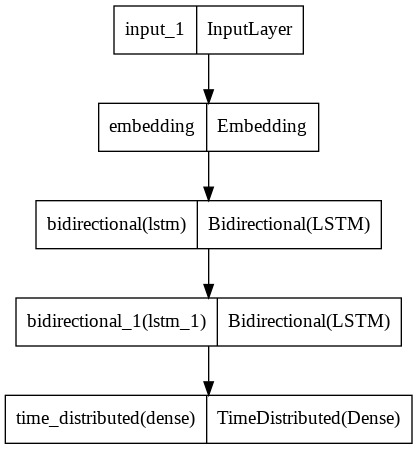

In [ ]:
#Architecture of bidirectional model 
tf.keras.utils.plot_model(bidirectional_model)

In [ ]:
# Fitting the model on train and val dataset
history_bidirectional_model = bidirectional_model.fit(train_data, validation_data=validation_data, epochs=5)

Epoch 1/5
174/174 [==============================] - 1802s 10s/step - loss: 0.4760 - accuracy: 0.8529 - val_loss: 0.2719 - val_accuracy: 0.8856
Epoch 2/5
174/174 [==============================] - 1791s 10s/step - loss: 0.2235 - accuracy: 0.9109 - val_loss: 0.2065 - val_accuracy: 0.9093
Epoch 3/5
174/174 [==============================] - 1800s 10s/step - loss: 0.1692 - accuracy: 0.9296 - val_loss: 0.1693 - val_accuracy: 0.9261
Epoch 4/5
174/174 [==============================] - 1867s 11s/step - loss: 0.1376 - accuracy: 0.9410 - val_loss: 0.1533 - val_accuracy: 0.9316
Epoch 5/5
174/174 [==============================] - 1823s 10s/step - loss: 0.1171 - accuracy: 0.9485 - val_loss: 0.1455 - val_accuracy: 0.9355


In [ ]:
# Saving the weights of bidirectional model
bidirectional_model.save_weights('/content/gdrive/MyDrive/Univ.AI/AI3/AI3_Project/bidirectional_model_weights.pkl')

Text(0.5, 0.98, 'Bidirectional RNN model: Training and validation loss as well as accuracy as per the epochs')

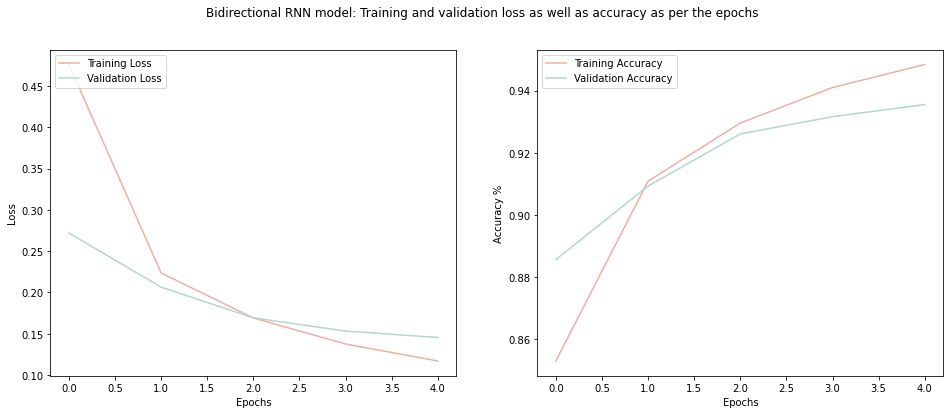

In [ ]:
# Plotting the training and validation loss and accuracy
fig, ax = plt.subplots(1,2,figsize = (16,6))
ax[0].plot(history_bidirectional_model.history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history_bidirectional_model.history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history_bidirectional_model.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history_bidirectional_model.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend(loc='upper left')
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('Bidirectional RNN model: Training and validation loss as well as accuracy as per the epochs')

In [ ]:
# Loading the saved weights of bidirectional model
bidirectional_model.load_weights('/content/gdrive/MyDrive/Univ.AI/AI3/AI3_Project/bidirectional_model_weights.pkl')

In [ ]:
# Checking the Performance of bidirectional rnn model on Train and val dataset
print("Bidirectional LSTM model's performance on train dataset: ", bidirectional_model.evaluate(train_data))
print("Bidirectional LSTM model's performance on validation dataset: ", bidirectional_model.evaluate(validation_data))

174/174 [==============================] - 216s 1s/step - loss: 0.1017 - accuracy: 0.9538
Bidirectional LSTM model's performance on train dataset:  [0.10166198015213013, 0.9537599682807922]
44/44 [==============================] - 51s 1s/step - loss: 0.1455 - accuracy: 0.9355
Bidirectional LSTM model's performance on validation dataset:  [0.14550848305225372, 0.935533344745636]


In [ ]:
# Storing the train and validation accuracy of bidirectional model
bd_lstm_train_acc = bidirectional_model.evaluate(train_data)[1]
bd_lstm_val_acc = bidirectional_model.evaluate(validation_data)[1]

44/44 [==============================] - 53s 1s/step - loss: 0.1455 - accuracy: 0.9355


**Comments on Bidirectional LSTM model. (2 Bidirectional LSTM layers) -** <br>
As seen from above evaluation and accuracy,loss plots of Bidirectional LSTM model, with just 2 Bidirectional LSTM layers and embeddings from scratch, the model is performing better than the baseline model on train as well as validation data giving accuracy of 95.3% on train data and 93.5% on validation data.

##### **6.3 - Baseline Model - A simple RNN network with 2 layers using Word2Vec Embeddings.**

In [ ]:
# Loading the word2vec embeddings
embeddings_path = '/content/gdrive/MyDrive/Univ.AI/AI3/GoogleNews-vectors-negative300.bin.gz'
word_2_vec = KeyedVectors.load_word2vec_format(embeddings_path, binary=True)

In [ ]:
# Getting the words from vocab dictionary
vocab_words = list(vocab.keys())

# Finding the com_words between our vocab and word_2_vec
word2vec_vocab = list(word_2_vec.vocab)
com_words = list(set(vocab_words) & set(word2vec_vocab))

# Printing the commn words
print('Common words in Word2Vec and our top 5001 words tokens are: ', len(com_words))

Common words in Word2Vec and our top 5000 words tokens are:  3693


In [ ]:
# Creating a dictionary for embeddings of all the common words.
com_embedding_dict = {w: word_2_vec[w] for w in com_words if w != '<UNK>'}

# Adding the UNK token embeddings as they it is not present in word_2_vec.
com_embedding_dict['<UNK>'] = np.random.uniform(low=-1, high=1, size=(300,))

# Creating embedding_dict a dictionary with tokens as word index and its embeddings as keys
embedding_dict = {}
vocab_present_tokens = []
for word in vocab_words:
  word_token = vocab[word]

  # if the word from vocab is not present in common words list, add the embeddings of '<UNK>'
  if word not in com_words:
    embedding_dict[word_token] = com_embedding_dict['<UNK>']   
  
  # else add the embeddings from com_embedding_dict
  else:
    embedding_dict[word_token] = com_embedding_dict[word]
    vocab_present_tokens.append(word_token)

In [ ]:
# Creating embedding matrix having token number as its index corresponding embeddings for that token number
embedding_matrix = np.zeros(shape=(len(embedding_dict)+1,300))
emb_dict_keys = list(embedding_dict.keys())
for k in emb_dict_keys:
  embedding_matrix[k] = embedding_dict[k]

# Dimension of embedding matrix
print("Dimension of embedding matrix: ",embedding_matrix.shape)

Dimension of embedding matrix:  (5002, 300)


As seen from above, we have got an embedding matrix of size of vocabulary i.e. 5001 each having 300 columns representing embeddings. 

In [ ]:
# Deleting the word_2_vec to free memory
del(word_2_vec)
gc.collect()

211

In [ ]:
tf.keras.backend.clear_session()

########## Baseline model architecture using Word2Vec Embeddings #########

# Defining the input
inputs = tf.keras.Input(shape=(None,), dtype=tf.float32)

# defining embedding layer using pretrained word2vec weights saved in embedding_matrix
# where the input dimension is the number of rows in embedding_matrix and output dimension is embedding dimension i.e. 300
embedding_input = tf.keras.layers.Embedding(input_dim=vocab_size+1,
                            output_dim=300,
                            weights=[embedding_matrix],
                            trainable=False,
                            mask_zero = True)(inputs)

# Defining the RNN layer 1
rnn1 = tf.keras.layers.SimpleRNN(300, return_sequences=True)
h1 = rnn1(embedding_input)

# Defining the RNN layer 2
rnn2 = tf.keras.layers.SimpleRNN(300,return_sequences=True)
h2 = rnn2(h1)

# Dense layer for prediction with activation as softmax
prediction = TimeDistributed(tf.keras.layers.Dense(63, activation='softmax'))(h2)

# Defining the baseline w2v model
baseline_w2v_model = tf.keras.Model(inputs=(inputs,), outputs=prediction)

# Compiling the model using sparse_categorical_crossentropy as loss and Adam as optimizer
baseline_w2v_model.compile(loss='sparse_categorical_crossentropy', 
                       optimizer=tf.keras.optimizers.Adam(0.001),
                       metrics='accuracy')

In [ ]:
# Checking summary of Baseline model using Word2Vec
baseline_w2v_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         1500600   
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 300)         180300    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 300)         180300    
                                                                 
 time_distributed (TimeDistr  (None, None, 63)         18963     
 ibuted)                                                         
                                                                 
Total params: 1,880,163
Trainable params: 379,563
Non-trainable params: 1,500,600
_____________________________________________

In [ ]:
# Fitting the model on train and val dataset
history_bm_w2v = baseline_w2v_model.fit(train_data, validation_data=validation_data, epochs=5)

Epoch 1/5
174/174 [==============================] - 178s 1s/step - loss: 0.5033 - accuracy: 0.8381 - val_loss: 0.3739 - val_accuracy: 0.8515
Epoch 2/5
174/174 [==============================] - 247s 1s/step - loss: 0.3456 - accuracy: 0.8696 - val_loss: 0.3237 - val_accuracy: 0.8633
Epoch 3/5
174/174 [==============================] - 195s 1s/step - loss: 0.3020 - accuracy: 0.8785 - val_loss: 0.2864 - val_accuracy: 0.8728
Epoch 4/5
174/174 [==============================] - 176s 1s/step - loss: 0.2854 - accuracy: 0.8831 - val_loss: 0.2991 - val_accuracy: 0.8729
Epoch 5/5
174/174 [==============================] - 175s 1s/step - loss: 0.2668 - accuracy: 0.8890 - val_loss: 0.3176 - val_accuracy: 0.8734


In [ ]:
# Saving the weights of baseline word2vec rnn model
baseline_w2v_model.save_weights('/content/gdrive/MyDrive/Univ.AI/AI3/AI3_Project/rnn_baseline_model_using_w2v_weights.pkl')

Text(0.5, 0.98, 'RNN Baseline model using Word2Vec Embeddings: Training and validation loss as well as accuracy as per the epochs')

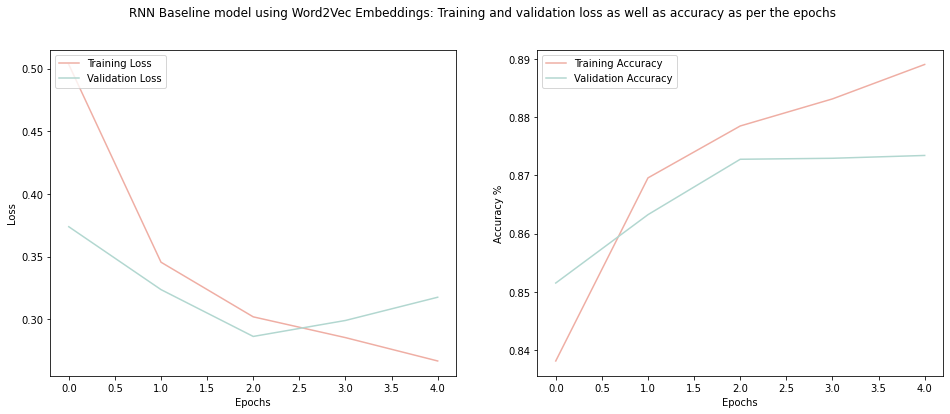

In [ ]:
# Plotting the training and validation loss and accuracy
fig, ax = plt.subplots(1,2,figsize = (16,6))
ax[0].plot(history_bm_w2v.history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history_bm_w2v.history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history_bm_w2v.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history_bm_w2v.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend(loc='upper left')
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('RNN Baseline model using Word2Vec Embeddings: Training and validation loss as well as accuracy as per the epochs')

In [ ]:
# Loading the saved weights of rnn w2v baseline model
baseline_w2v_model.load_weights('/content/gdrive/MyDrive/Univ.AI/AI3/AI3_Project/rnn_baseline_model_using_w2v_weights.pkl')

In [ ]:
# Checking the Performance of Baseline model on Train and val dataset
print("Baseline model using Word2Vec Embedding performance on train dataset: ", baseline_w2v_model.evaluate(train_data))
print("Baseline model using Word2Vec Embedding performance on validation dataset: ", baseline_w2v_model.evaluate(validation_data))

174/174 [==============================] - 32s 182ms/step - loss: 0.3200 - accuracy: 0.8850
Baseline model using Word2Vec Embedding performance on train dataset:  [0.32000255584716797, 0.8849743008613586]
44/44 [==============================] - 8s 183ms/step - loss: 0.3176 - accuracy: 0.8734
Baseline model using Word2Vec Embedding performance on validation dataset:  [0.3176306188106537, 0.873425304889679]


In [ ]:
# Storing the train and validation accuracy of Baseline w2v model
baseline_rnn_w2v_train_acc = baseline_w2v_model.evaluate(train_data)[1]
baseline_rnn_w2v_val_acc = baseline_w2v_model.evaluate(validation_data)[1]

44/44 [==============================] - 9s 208ms/step - loss: 0.3176 - accuracy: 0.8734


**Comments on baseline model using Word2Vec Embeddings-** <br>
As seen from above evaluation and accuracy,loss plots of baseline model using Word2Vec embeddings, as just 3693 words from corpus have embeddings present in Word2Vec, the rest of the words were replaced with the embeddings of 'UNK' tag. This would have caused the accuracy of model to be less than that baseline model from scratch.

##### **6.4 - Bidirectional LSTM model using Word2Vec Embeddings.**

In [ ]:
tf.keras.backend.clear_session()

########## Bidirectional LSTM model architecture using Word2Vec Embeddings #########

# Defining the input
inputs = tf.keras.Input(shape=(None,), dtype=tf.float32)

# defining embedding layer using pretrained word2vec weights saved in embedding_matrix
# where the input dimension is the number of rows in embedding_matrix and output dimension is embedding dimension i.e. 300
embedding_input = tf.keras.layers.Embedding(input_dim=vocab_size+1,
                            output_dim=300,
                            weights=[embedding_matrix],
                            trainable=False,
                            mask_zero = True)(inputs)

# Defining the LSTM layer 1
lstm1 = Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True))
h1 = lstm1(embedding_input)

# Defining the LSTM layer 2
lstm2 = Bidirectional(tf.keras.layers.LSTM(150,return_sequences=True))
h2 = lstm2(h1)

# Dense layer for prediction with activation as softmax
prediction = TimeDistributed(tf.keras.layers.Dense(63, activation='softmax'))(h2)

# Defining the baseline model
bidlstm_model_w2v = tf.keras.Model(inputs=(inputs,), outputs=prediction)

# Compiling the model using sparse_categorical_crossentropy as loss and Adam as optimizer
bidlstm_model_w2v.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics='accuracy')

In [ ]:
# Checking summary of Baseline model using Word2Vec
bidlstm_model_w2v.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         1500600   
                                                                 
 bidirectional (Bidirectiona  (None, None, 300)        541200    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 300)        541200    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, None, 63)         18963     
 ibuted)                                                         
                                                             

In [ ]:
# Fitting the model on train and val dataset
history_bm_w2v = bidlstm_model_w2v.fit(train_data, 
                                      validation_data=validation_data, 
                                      epochs=5)

Epoch 1/5
174/174 [==============================] - 593s 3s/step - loss: 0.4944 - accuracy: 0.8416 - val_loss: 0.3422 - val_accuracy: 0.8578
Epoch 2/5
174/174 [==============================] - 568s 3s/step - loss: 0.3049 - accuracy: 0.8799 - val_loss: 0.2922 - val_accuracy: 0.8741
Epoch 3/5
174/174 [==============================] - 739s 4s/step - loss: 0.2654 - accuracy: 0.8909 - val_loss: 0.2581 - val_accuracy: 0.8782
Epoch 4/5
174/174 [==============================] - 681s 4s/step - loss: 0.2373 - accuracy: 0.8998 - val_loss: 0.2328 - val_accuracy: 0.8910
Epoch 5/5
174/174 [==============================] - 569s 3s/step - loss: 0.2155 - accuracy: 0.9065 - val_loss: 0.2221 - val_accuracy: 0.8946


In [ ]:
# Saving the weights of bidirectional model using Word2Vec embeddings
bidlstm_model_w2v.save_weights('/content/gdrive/MyDrive/Univ.AI/AI3/AI3_Project/bidirectional_model_using_w2v_weights.pkl')

Text(0.5, 0.98, 'Bidirectional LSTM model using Word2Vec Embeddings: Training and validation loss as well as accuracy as per the epochs')

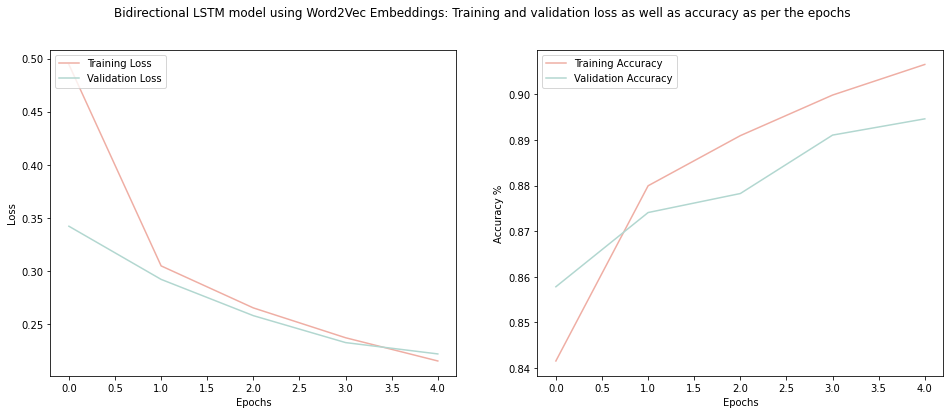

In [ ]:
# Plotting the training and validation loss and accuracy
fig, ax = plt.subplots(1,2,figsize = (16,6))
ax[0].plot(history_bm_w2v.history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history_bm_w2v.history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history_bm_w2v.history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history_bm_w2v.history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend(loc='upper left')
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('Bidirectional LSTM model using Word2Vec Embeddings: Training and validation loss as well as accuracy as per the epochs')

In [ ]:
# Loading the saved weights of bidirectional model using Word2Vec embeddings
bidlstm_model_w2v.load_weights('/content/gdrive/MyDrive/Univ.AI/AI3/AI3_Project/bidirectional_model_using_w2v_weights.pkl')

In [ ]:
# Checking the Performance of bidirectional rnn model on Train and val dataset
print("Bidirectional LSTM (using Word2Vec) model's performance on train dataset: ", bidlstm_model_w2v.evaluate(train_data))
print("Bidirectional LSTM (using Word2Vec) model's performance on validation dataset: ", bidlstm_model_w2v.evaluate(validation_data))

174/174 [==============================] - 136s 782ms/step - loss: 0.2084 - accuracy: 0.9083
Bidirectional LSTM (using Word2Vec) model's performance on train dataset:  [0.208370178937912, 0.9083309173583984]
44/44 [==============================] - 32s 727ms/step - loss: 0.2221 - accuracy: 0.8946
Bidirectional LSTM (using Word2Vec) model's performance on validation dataset:  [0.22209566831588745, 0.8946047425270081]


In [ ]:
# Storing the train and validation accuracy of bidirectional model using Word2Vec embeddings 
bd_lstm_w2v_train_acc = bidlstm_model_w2v.evaluate(train_data)[1]
bd_lstm_w2v_val_acc = bidlstm_model_w2v.evaluate(validation_data)[1]

44/44 [==============================] - 33s 741ms/step - loss: 0.2221 - accuracy: 0.8946


**Comments on Bidirectional LSTM model using Word2Vec Embeddings-** <br>
As seen from above evaluation and accuracy,loss plots of Bidirectional LSTM model using Word2Vec Embeddings, it performs poorly as compared to the Bidirectional LSTM model. As just 3693 words from corpus have embeddings present in Word2Vec, the rest of the words were replaced with the embeddings of 'UNK' tag, this would have caused the accuracy of model to be less than that Bidirectional LSTM model from scratch.

##### **6.5 - Comparison of models.** 


In [ ]:
### Creating table showing train and validation accuracy of all 4 models ###
# Specifing the Column Names while initializing the Table
Comp_table = PrettyTable(["Model", "Train Accuracy", "Validation Accuracy"])
 
# Adding rows
Comp_table.add_row(["Baseline Model (2 SimpleRNN layers)", np.round(baseline_rnn_train_acc,3), np.round(baseline_rnn_val_acc,3) ])
Comp_table.add_row(["Bidirectional LSTM model", np.round(bd_lstm_train_acc,3), np.round(bd_lstm_val_acc,3) ])
Comp_table.add_row(["Baseline Model (Using Word2Vec Embeddings)", np.round(baseline_rnn_w2v_train_acc,3), np.round(baseline_rnn_w2v_val_acc,3) ])
Comp_table.add_row(["Bidirectional LSTM (Using Word2Vec Embeddings) model", np.round(bd_lstm_w2v_train_acc,3), np.round(bd_lstm_w2v_val_acc,3) ])
 
# Printing the table
print("Training and Vakidation Accuracies of Models trained - ")
print(Comp_table)

Training and Vakidation Accuracies of Models trained - 
+------------------------------------------------------+----------------+---------------------+
|                        Model                         | Train Accuracy | Validation Accuracy |
+------------------------------------------------------+----------------+---------------------+
|         Baseline Model (2 SimpleRNN layers)          |     0.936      |        0.916        |
|               Bidirectional LSTM model               |     0.954      |        0.936        |
|      Baseline Model (Using Word2Vec Embeddings)      |     0.885      |        0.873        |
| Bidirectional LSTM (Using Word2Vec Embeddings) model |     0.908      |        0.895        |
+------------------------------------------------------+----------------+---------------------+


As seen from the above comparison table - <br>

**Best model** - Bidirectional LSTM model having train accuracy of 95.4% and validation accuracy of 93.6%.

#### **7. Evaluating model using validation data.**

Evaluating our best model - **bidirectional_model**  using Validation data.

In [ ]:
# Getting the index of rows in validation (X_val) data
val_indexes = list(X_val.index)

# Getting the index of rows in train_data df
train_df_indexes = list(train_data_df.index)

# Getting common indexes between val_indexes and train_df_indexes
def common(a,b): 
    c = [value for value in a if value in b] 
    return c
ci = common(val_indexes,train_df_indexes)


# From train_data_df, selecting only the validation data rows
# using val_indexes list
val_data = train_data_df.iloc[ci]
print("Shape  of Validation data: ",val_data.shape)
val_data.head()

Shape  of Validation data:  (348, 4)


,ner_ids,ner_tags,tokens,Tokenized_Data
906,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[2015, )., For, illustration,, in, Fig., 3, we...","[110, 24, 83, 1, 5, 44, 60, 20, 598, 2, 223, 3..."
267,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 22, 53, 2...","[O, O, O, O, O, O, O, O, O, B-Person, I-Person...","[We, would, like, to, acknowledge, the, pionee...","[21, 96, 274, 6, 140, 2, 1, 67, 3, 1, 1, 1, 1,..."
1070,"[62, 62, 62, 62, 62, 62, 4, 35, 35, 35, 35, 62...","[O, O, O, O, O, O, B-Citation, I-Citation, I-C...","[the, turbulence-regulated, star, formation, m...","[2, 1, 126, 199, 58, 3, 1, 1, 30, 430, 52, 6, ..."
1410,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[We, would, like, to, thank, the, anonymous, r...","[21, 96, 274, 6, 50, 2, 197, 156, 9, 786, 193,..."
403,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 22, 53, 5...","[O, O, O, O, O, O, O, O, O, B-Person, I-Person...","[We, acknowledge, insights, and, assistance, w...","[21, 140, 4622, 4, 2230, 11, 36, 159, 10, 1, 1..."


In [ ]:
# Creating a new column 'predicted_ner_ids' which would contain 
# predicted ner ids for respective sentence using our best model
# 'bidirectional_model'
val_data['Predicted_NER_tag_ids'] = None
for idx in val_data.index:
  prediction = bidirectional_model.predict([val_data['Tokenized_Data'][idx]]).argmax(axis=-1)
  val_data['Predicted_NER_tag_ids'][idx] = prediction.tolist()

  # Flattening the predictions to a single list
  val_data['Predicted_NER_tag_ids'][idx] = sum(val_data['Predicted_NER_tag_ids'][idx], [])

# Viewing the first few row of val_data which has a new column of predictions 'Predicted_NER_tag_ids'
val_data.head()

,ner_ids,ner_tags,tokens,Tokenized_Data,Predicted_NER_tag_ids
906,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[2015, )., For, illustration,, in, Fig., 3, we...","[110, 24, 83, 1, 5, 44, 60, 20, 598, 2, 223, 3...","[35, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6..."
267,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 22, 53, 2...","[O, O, O, O, O, O, O, O, O, B-Person, I-Person...","[We, would, like, to, acknowledge, the, pionee...","[21, 96, 274, 6, 140, 2, 1, 67, 3, 1, 1, 1, 1,...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 2..."
1070,"[62, 62, 62, 62, 62, 62, 4, 35, 35, 35, 35, 62...","[O, O, O, O, O, O, B-Citation, I-Citation, I-C...","[the, turbulence-regulated, star, formation, m...","[2, 1, 126, 199, 58, 3, 1, 1, 30, 430, 52, 6, ...","[62, 62, 62, 62, 62, 62, 4, 35, 35, 35, 35, 62..."
1410,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[We, would, like, to, thank, the, anonymous, r...","[21, 96, 274, 6, 50, 2, 197, 156, 9, 786, 193,...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6..."
403,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 22, 53, 5...","[O, O, O, O, O, O, O, O, O, B-Person, I-Person...","[We, acknowledge, insights, and, assistance, w...","[21, 140, 4622, 4, 2230, 11, 36, 159, 10, 1, 1...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 27, 62, 2..."


In [ ]:
# Creating a new column 'predicted_ner_tags' which would contain 
# ner tags corresponding to predicted ner ids
val_data['Predicted_NER_tags'] = None
for idx in val_data.index:
  tag_ids = val_data['Predicted_NER_tag_ids'][idx]
  tags = []
  for t in tag_ids:
    tags.append(ner_id_tags_dict[t])
  val_data['Predicted_NER_tags'][idx] = tags

# Viewing the first few row of val_data which has a new column of 'Predicted_NER_tags'
# containing tags corresponding to predicted tag_ids
val_data.head(3)

,ner_ids,ner_tags,tokens,Tokenized_Data,Predicted_NER_tag_ids,Predicted_NER_tags
906,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[2015, )., For, illustration,, in, Fig., 3, we...","[110, 24, 83, 1, 5, 44, 60, 20, 598, 2, 223, 3...","[35, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[I-Citation, O, O, O, O, O, O, O, O, O, O, O, ..."
267,"[62, 62, 62, 62, 62, 62, 62, 62, 62, 22, 53, 2...","[O, O, O, O, O, O, O, O, O, B-Person, I-Person...","[We, would, like, to, acknowledge, the, pionee...","[21, 96, 274, 6, 140, 2, 1, 67, 3, 1, 1, 1, 1,...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 2...","[O, O, O, O, O, O, O, O, O, O, O, B-Person, O,..."
1070,"[62, 62, 62, 62, 62, 62, 4, 35, 35, 35, 35, 62...","[O, O, O, O, O, O, B-Citation, I-Citation, I-C...","[the, turbulence-regulated, star, formation, m...","[2, 1, 126, 199, 58, 3, 1, 1, 30, 430, 52, 6, ...","[62, 62, 62, 62, 62, 62, 4, 35, 35, 35, 35, 62...","[O, O, O, O, O, O, B-Citation, I-Citation, I-C..."


In [ ]:
# Dropping the 'Tokenized_Data' column from val_data as it is not need now for evaluating model
val_data.drop('Tokenized_Data', axis=1, inplace = True)

In [ ]:
# Using df.explode on val_data for all columns to get single tokens and its corresponding data in a row
val_data_exp = val_data.explode(['ner_ids', 'ner_tags', 'tokens', 'Predicted_NER_tag_ids', 'Predicted_NER_tags'])
print("Shape after separating tokens and its corresponding predicted and actual ner tags and ids: ",val_data_exp.shape)


# Viewing first few rows of exploded val_data_exp
val_data_exp.head()

Shape after separating tokens and its corresponding predicted and actual ner tags and ids:  (105574, 5)


,ner_ids,ner_tags,tokens,Predicted_NER_tag_ids,Predicted_NER_tags
906,62,O,2015,35,I-Citation
906,62,O,).,62,O
906,62,O,For,62,O
906,62,O,"illustration,",62,O
906,62,O,in,62,O


##### **7.1 - Classification report.** 

In [ ]:
#### CLASSIFICATION REPORT ####
actual_tags = val_data_exp['ner_tags'].tolist()
predicted_tags = val_data_exp['Predicted_NER_tags'].tolist()
class_report_n = classification_report(actual_tags, predicted_tags)
print(class_report_n)

                           precision    recall  f1-score   support

                B-Archive       0.67      0.59      0.62        51
        B-CelestialObject       0.59      0.32      0.41       490
  B-CelestialObjectRegion       0.00      0.00      0.00        56
        B-CelestialRegion       0.00      0.00      0.00        15
               B-Citation       0.92      0.87      0.89      1140
          B-Collaboration       0.80      0.63      0.70        70
      B-ComputingFacility       0.43      0.40      0.41        83
               B-Database       0.86      0.64      0.73        66
                B-Dataset       0.00      0.00      0.00        62
 B-EntityOfFutureInterest       0.00      0.00      0.00        13
                  B-Event       0.00      0.00      0.00        15
             B-Fellowship       0.70      0.34      0.46        77
                B-Formula       0.72      0.83      0.77       417
                  B-Grant       0.57      0.64      0.60     

**Comments on Classification Report -** <br>
As there is class imbalance in our dataset, we would look upto **F1-Score** as evaluation metrics which takes into account not only the number of prediction errors that our model makes, but that also look at the type of errors that are made. F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Higher the F1-score, the better it is.

From the classification report we can figure out what weigthage is given to each of the tags by our best model. There is dominance of 'O' tag in data due to which its  F1-score is the highest. But, few of the other tags which are higher incounts after 'O' also have high  F1-scores indicating that our model would predict entities well rather than just predicting 'O' tag.

##### **7.2 - Actual tags VS Predicted tags for a validation input.** 

Taking one sentence from validation data and checking its actual vs predicted tags.

In [ ]:
# Choosing one input from val_data_exp 
eg1_df = val_data_exp[val_data_exp.index==267]

In [ ]:
# Printing the sentence
Sentence = [' '.join(eg1_df['tokens'])]
print("Sentence:\n")
Sentence

Sentence:



['We would like to acknowledge the pioneering work of Adam Burrows, Hans-Thomas Janka, and Matthias Liebendörfer, whose contributions to CCSN theory were directly inspirational to the work presented here. This material is based upon work supported by the National Science Foundation under Grant No. 1313036.']

In [ ]:
# Printing the Actual tags corresponding to sentence tokens
eg1_df['Token_Tag'] = eg1_df['tokens'] + "[" + eg1_df['ner_tags'] + "]"
actual_NER = [' '.join(eg1_df['Token_Tag'])]
print("Actual tags for input sentence :\n")
actual_NER

Actual tags for input sentence :



['We[O] would[O] like[O] to[O] acknowledge[O] the[O] pioneering[O] work[O] of[O] Adam[B-Person] Burrows,[I-Person] Hans-Thomas[B-Person] Janka,[I-Person] and[O] Matthias[B-Person] Liebendörfer,[I-Person] whose[O] contributions[O] to[O] CCSN[B-Model] theory[I-Model] were[O] directly[O] inspirational[O] to[O] the[O] work[O] presented[O] here.[O] This[O] material[O] is[O] based[O] upon[O] work[O] supported[O] by[O] the[O] National[B-Organization] Science[I-Organization] Foundation[I-Organization] under[O] Grant[B-Grant] No.[I-Grant] 1313036.[I-Grant]']

In [ ]:
# Predicted tags for input sentence tokens
eg1_df['Pred_Token_Tag'] = eg1_df['tokens'] + "[" + eg1_df['Predicted_NER_tags'] + "]"
pred_NER = [' '.join(eg1_df['Pred_Token_Tag'])]
print("Predicted tags for input sentence:\n")
pred_NER

Predicted tags for input sentence:



['We[O] would[O] like[O] to[O] acknowledge[O] the[O] pioneering[O] work[O] of[O] Adam[O] Burrows,[O] Hans-Thomas[B-Person] Janka,[O] and[O] Matthias[O] Liebendörfer,[O] whose[O] contributions[O] to[O] CCSN[O] theory[O] were[O] directly[O] inspirational[O] to[O] the[O] work[O] presented[O] here.[O] This[O] material[O] is[O] based[O] upon[O] work[O] supported[O] by[O] the[O] National[B-Organization] Science[I-Organization] Foundation[I-Organization] under[O] Grant[O] No.[O] 1313036.[B-Grant]']

As seen from above actual tags VS predicted tags for a validation sentence, we can see that most of the tags have been predicted correctly.

#### **8. Making predictions on test data**
Using the best model (Bidirectional LSTM model) to predict on test sentences.

In [ ]:
# Printing the test data head
test_data.head()

,tokens,Tokenized_Data
0,"[that, gas, outside, halos,, not, necessarily,...","[15, 98, 1289, 1, 39, 2663, 353, 266, 166, 172..."
1,"[that, all, star, formation, within, Upper, Sc...","[15, 74, 126, 199, 119, 3498, 1, 41, 1, 2209, ..."
2,"[the, PCs, would, contain, the, changes., Mate...","[2, 1, 96, 2023, 2, 1, 1, 15, 17, 1, 13, 2, 25..."
3,"[arcmin, away,, in, a, low, density, environme...","[3538, 1, 5, 8, 228, 78, 2182, 1, 14, 16, 1016..."
4,"[We, are, grateful, to, J., Chen,, J., Delabro...","[21, 17, 329, 6, 1846, 1, 1846, 1, 1, 1, 1846,..."


In [ ]:
### Predicting ner tag ids using bidirectional_model ###

# Creating a new column 'predicted_ner_ids' which would contain 
# predicted ner ids for respective sentence using our best model
# 'bidirectional_model'
test_data['Predicted_NER_tag_ids'] = None
for idx in test_data.index:
  prediction = bidirectional_model.predict([test_data['Tokenized_Data'][idx]]).argmax(axis=-1)
  test_data['Predicted_NER_tag_ids'][idx] = prediction.tolist()

  # Flattening the predictions to a single list
  test_data['Predicted_NER_tag_ids'][idx] = sum(test_data['Predicted_NER_tag_ids'][idx], [])

# Viewing the first few row of test_data which has a new column of predictions 'Predicted_NER_tag_ids'
test_data.head()

,tokens,Tokenized_Data,Predicted_NER_tag_ids
0,"[that, gas, outside, halos,, not, necessarily,...","[15, 98, 1289, 1, 39, 2663, 353, 266, 166, 172...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6..."
1,"[that, all, star, formation, within, Upper, Sc...","[15, 74, 126, 199, 119, 3498, 1, 41, 1, 2209, ...","[62, 62, 62, 62, 62, 1, 62, 62, 62, 62, 62, 4,..."
2,"[the, PCs, would, contain, the, changes., Mate...","[2, 1, 96, 2023, 2, 1, 1, 15, 17, 1, 13, 2, 25...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6..."
3,"[arcmin, away,, in, a, low, density, environme...","[3538, 1, 5, 8, 228, 78, 2182, 1, 14, 16, 1016...","[62, 62, 62, 62, 62, 62, 62, 4, 35, 35, 35, 4,..."
4,"[We, are, grateful, to, J., Chen,, J., Delabro...","[21, 17, 329, 6, 1846, 1, 1846, 1, 1, 1, 1846,...","[62, 62, 62, 62, 22, 53, 22, 53, 22, 53, 22, 5..."


In [ ]:
# Creating a new column 'predicted_ner_tags' which would contain 
# ner tags corresponding to predicted ner ids
test_data['Predicted_NER_tags'] = None
for idx in test_data.index:
  tag_ids = test_data['Predicted_NER_tag_ids'][idx]
  tags = []
  for t in tag_ids:
    tags.append(ner_id_tags_dict[t])
  test_data['Predicted_NER_tags'][idx] = tags

# Viewing the first few row of test_data which has a new column of 'Predicted_NER_tags'
# containing tags corresponding to predicted tag_ids
test_data.head(3)

,tokens,Tokenized_Data,Predicted_NER_tag_ids,Predicted_NER_tags
0,"[that, gas, outside, halos,, not, necessarily,...","[15, 98, 1289, 1, 39, 2663, 353, 266, 166, 172...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[that, all, star, formation, within, Upper, Sc...","[15, 74, 126, 199, 119, 3498, 1, 41, 1, 2209, ...","[62, 62, 62, 62, 62, 1, 62, 62, 62, 62, 62, 4,...","[O, O, O, O, O, B-CelestialObject, O, O, O, O,..."
2,"[the, PCs, would, contain, the, changes., Mate...","[2, 1, 96, 2023, 2, 1, 1, 15, 17, 1, 13, 2, 25...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
# Dropping the 'Tokenized_Data' as it is no longer needed
test_data.drop('Tokenized_Data', axis=1, inplace=True)

In [ ]:
##### PREDICTIONS ON TEST DATA ####
test_data.head()

,tokens,Predicted_NER_tag_ids,Predicted_NER_tags
0,"[that, gas, outside, halos,, not, necessarily,...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[that, all, star, formation, within, Upper, Sc...","[62, 62, 62, 62, 62, 1, 62, 62, 62, 62, 62, 4,...","[O, O, O, O, O, B-CelestialObject, O, O, O, O,..."
2,"[the, PCs, would, contain, the, changes., Mate...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3,"[arcmin, away,, in, a, low, density, environme...","[62, 62, 62, 62, 62, 62, 62, 4, 35, 35, 35, 4,...","[O, O, O, O, O, O, O, B-Citation, I-Citation, ..."
4,"[We, are, grateful, to, J., Chen,, J., Delabro...","[62, 62, 62, 62, 22, 53, 22, 53, 22, 53, 22, 5...","[O, O, O, O, B-Person, I-Person, B-Person, I-P..."


As seen from the last row of the above output, names of the persons have been correctly tagged.

#### **9. Conclusion**

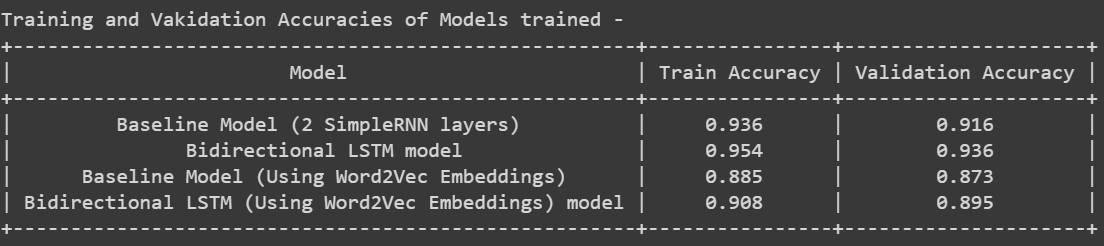

**Best model - Bidirectional LSTM model having train accuracy of 95.4% and validation accuracy of 93.6%.**

**Inference: Classification Report of Best model -**<br>
As there is **class imbalance** in our dataset, we would look upto **F1-Score as evaluation metrics** which takes into account not only the number of prediction errors that our model makes, but that also look at the type of errors that are made. F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Higher the F1-score, the better it is.

From the classification report we can figure out what weigthage is given to each of the tags by our best model. There is dominance of 'O' tag in data due to which its F1-score is the highest. But, few of the other tags which are higher in counts after 'O' also have high F1-scores indicating that our model would predict entities well rather than just predicting 'O' tag.

**Future Scope -**<br>
We would like to work on improving the F1_scores of rest of the tags by getting more data (tokens) of the tags which are less in the current dataset. Also use Transformers to improve our model further.



We tried working using BERT but we were getting some errors in it so we weren't able to complete it. The link of the BERT notebook is - 

https://drive.google.com/file/d/1G4o5B84IgeCmguO2YLYGpEh5KWGWUnqS/view?usp=sharing 